In [ ]:
import numpy as np
import scipy.sparse

In [ ]:
# Load labels (0 = real, 1 = fake)
labels = np.load("/content/drive/MyDrive/Data/graph_labels.npy")

# Load metadata (profile feature)
from scipy.sparse import load_npz
profile_sparse = load_npz("/content/drive/MyDrive/Data/new_profile_feature.npz")
profile = profile_sparse.toarray()

# Load content feature (TF-IDF or handcrafted)
content_sparse = load_npz("/content/drive/MyDrive/Data/new_content_feature.npz")
content = content_sparse.toarray()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Profile shape:", profile.shape)
print("Sample row:", profile[0])


Profile shape: (41054, 10)
Sample row: [0.00000000e+00 0.00000000e+00 1.30814989e-04 3.48118758e-03
 8.60901460e-03 5.20881161e-03 1.13039020e-03 3.10654010e-01
 1.49951321e-01 3.15999551e-01]


In [ ]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import numpy as np
from scipy.sparse import load_npz

# Load profile features
profile = load_npz("/content/drive/MyDrive/Data/new_profile_feature.npz").toarray()

# Build k-NN graph (cosine similarity)
k = 5  # or 10 for more edges
nn = NearestNeighbors(n_neighbors=k+1, metric='cosine', algorithm='brute').fit(profile)
distances, indices = nn.kneighbors(profile)

# Build graph
G = nx.Graph()
G.add_nodes_from(range(profile.shape[0]))

# Add edges (ignore self-loop at indices[i][0])
for i in range(profile.shape[0]):
    for j in indices[i][1:]:
        G.add_edge(i, j)

print("✅ Graph constructed using k-NN.")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


✅ Graph constructed using k-NN.
Nodes: 41054
Edges: 152965


In [ ]:
import torch


edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
print("edge_index shape:", edge_index.shape)

edge_index shape: torch.Size([2, 152965])


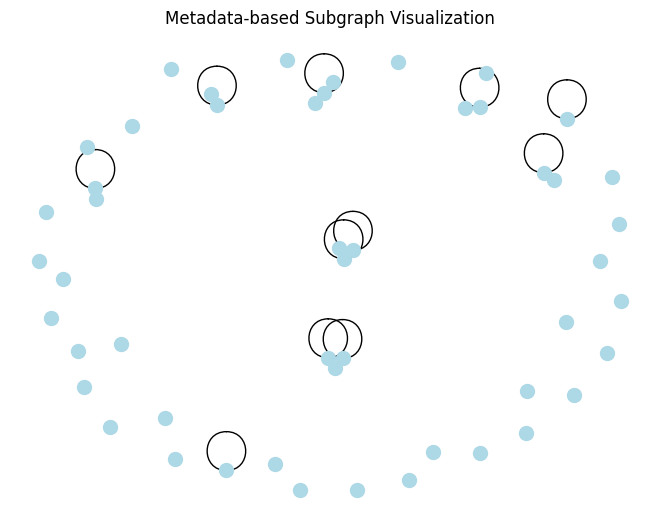

In [ ]:
import matplotlib.pyplot as plt

sample = G.subgraph(list(G.nodes)[:50])  # Visualize 50-node slice
nx.draw(sample, with_labels=False, node_color='lightblue', node_size=100)
plt.title("Metadata-based Subgraph Visualization")
plt.show()


In [ ]:
from scipy.sparse import load_npz

# Node features (could be TF-IDF or handcrafted)
x_sparse = load_npz("/content/drive/MyDrive/Data/new_content_feature.npz")
x = torch.tensor(x_sparse.toarray(), dtype=torch.float)

# Labels (e.g., 0 = real, 1 = fake)
y = torch.tensor(np.load("/content/drive/MyDrive/Data/graph_labels.npy"), dtype=torch.long)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# y is a torch tensor; convert it manually to NumPy array
labels_np = np.load("/content/drive/MyDrive/Data/graph_labels.npy")  # Use NumPy from source

# Use NumPy indices as well
labeled_idx = np.arange(len(labels_np))

# Stratified split
train_idx_np, test_idx_np = train_test_split(
    labeled_idx,
    test_size=0.4,
    stratify=labels_np,
    random_state=42
)

# Convert back to PyTorch for training
import torch
train_idx = torch.tensor(train_idx_np, dtype=torch.long)
test_idx = torch.tensor(test_idx_np, dtype=torch.long)

# Re-assign y from original labels_np
y = torch.tensor(labels_np, dtype=torch.long)


In [ ]:
# Install torch_geometric
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00


In [ ]:
from torch_geometric.data import Data

data = Data(
    x=x,
    edge_index=edge_index,
    y=y
)


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
model = GraphSAGE(
    in_channels=data.x.shape[1],
    hidden_channels=128,
    out_channels=2  # Binary classification
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def evaluate(model, data, idx, y):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        preds = out[idx].argmax(dim=1)
        correct = (preds == y[idx]).sum().item()
        acc = correct / len(idx)
    return acc

# Training Loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == 49:
        train_acc = evaluate(model, data, train_idx, data.y)
        test_acc = evaluate(model, data, test_idx, data.y)
        print(f"Epoch {epoch:02d}: Loss={loss.item():.4f} | Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f}")


Epoch 00: Loss=0.7046 | Train Acc=0.5000 | Test Acc=0.5000
Epoch 05: Loss=0.7002 | Train Acc=0.5266 | Test Acc=0.5238
Epoch 10: Loss=0.7105 | Train Acc=0.5000 | Test Acc=0.5000
Epoch 15: Loss=0.7069 | Train Acc=0.6064 | Test Acc=0.6587
Epoch 20: Loss=0.7058 | Train Acc=0.5000 | Test Acc=0.5079
Epoch 25: Loss=0.6885 | Train Acc=0.5266 | Test Acc=0.5317
Epoch 30: Loss=0.6916 | Train Acc=0.5106 | Test Acc=0.5317
Epoch 35: Loss=0.6887 | Train Acc=0.5798 | Test Acc=0.5397
Epoch 40: Loss=0.6935 | Train Acc=0.5319 | Test Acc=0.5317
Epoch 45: Loss=0.6917 | Train Acc=0.5319 | Test Acc=0.5238
Epoch 49: Loss=0.6918 | Train Acc=0.5266 | Test Acc=0.5317


              precision    recall  f1-score   support

           0     0.5476    0.3651    0.4381        63
           1     0.5238    0.6984    0.5986        63

    accuracy                         0.5317       126
   macro avg     0.5357    0.5317    0.5184       126
weighted avg     0.5357    0.5317    0.5184       126



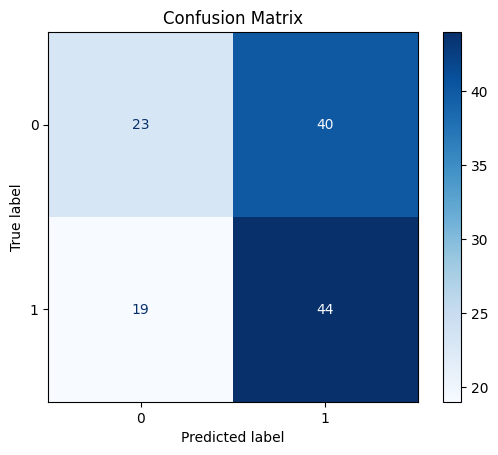

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    preds = logits[test_idx].argmax(dim=1)
    truths = data.y[test_idx]

print(classification_report(
    truths.detach().cpu().tolist(),
    preds.detach().cpu().tolist(),
    digits=4
))
cm = confusion_matrix(
    truths.detach().cpu().tolist(),
    preds.detach().cpu().tolist()
)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Applying Community Detection Algorithms

In [ ]:
import networkx as nx


G = nx.Graph()
G.add_edges_from(edge_index.t().tolist())

In [ ]:
!pip install python-louvain

In [ ]:
import torch
import networkx as nx
from torch_geometric.utils import to_networkx
from networkx.algorithms.community import girvan_newman
import matplotlib.pyplot as plt

# Assuming `data` is your PyTorch Geometric Data object
# Convert edge_index to NetworkX graph
G = to_networkx(data, to_undirected=True)

# --- DEGREE CENTRALITY ---
deg_cent = nx.degree_centrality(G)

# --- EIGENVECTOR CENTRALITY ---
eig_cent = nx.eigenvector_centrality(G, max_iter=1000)

# Print top 5 influential nodes
top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_eig = sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top Degree Centrality:")
for node, score in top_deg:
    print(f"Node {node}: {score:.4f}")

print("\nTop Eigenvector Centrality:")
for node, score in top_eig:
    print(f"Node {node}: {score:.4f}")


Top Degree Centrality:
Node 24922: 0.0022
Node 25157: 0.0022
Node 25261: 0.0022
Node 25263: 0.0022
Node 25380: 0.0022

Top Eigenvector Centrality:
Node 24922: 0.3076
Node 25157: 0.3076
Node 25261: 0.3076
Node 25263: 0.3076
Node 25380: 0.3076



🔹 Top Degree Centrality Nodes:
  Node 0 → 0.0553
  Node 24 → 0.0553
  Node 191 → 0.0553

🔹 Top Eigenvector Centrality Nodes:
  Node 0 → 0.4675
  Node 24 → 0.4675
  Node 191 → 0.4675

🔹 Top Closeness Centrality Nodes:
  Node 36755 → 0.0416
  Node 8756 → 0.0415
  Node 14645 → 0.0414

🔹 Top Betweenness Centrality Nodes:
  Node 0 → 0.0004
  Node 24 → 0.0004
  Node 191 → 0.0004


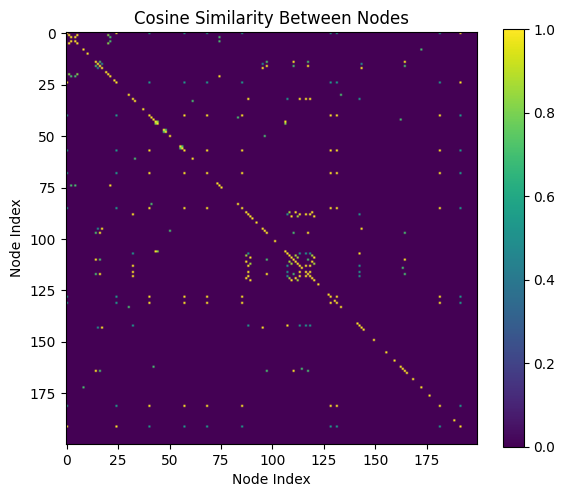

In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

small_nodes = list(G.nodes)[:200]
subG = G.subgraph(small_nodes)
# === Step 2: Centrality Measures ===

# Degree Centrality
deg_cent = nx.degree_centrality(subG)

# Eigenvector Centrality
eig_cent = nx.eigenvector_centrality(subG, max_iter=1000)

# Betweenness Centrality
btw_cent = nx.betweenness_centrality(subG)

# Display top 3 per metric
def print_top(metric_dict, label):
    print(f"\n🔹 Top {label} Centrality Nodes:")
    for n, s in sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  Node {n} → {s:.4f}")

print_top(deg_cent, "Degree")
print_top(eig_cent, "Eigenvector")
print_top(clo_cent, "Closeness")
print_top(btw_cent, "Betweenness")

# === Step 3: Similarity Matrix (Cosine over Adjacency) ===

# Convert to adjacency matrix (dense)
adj = nx.to_numpy_array(subG)

# Cosine similarity between node adjacency vectors
sim_matrix = cosine_similarity(adj)

# Plot similarity matrix
plt.figure(figsize=(6, 5))
plt.imshow(sim_matrix, cmap='viridis')
plt.colorbar()
plt.title("Cosine Similarity Between Nodes")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.tight_layout()
plt.show()


In [ ]:
  import community  # This is the python-louvain package
import matplotlib.pyplot as plt

# Run Louvain community detection
partition = community.best_partition(G)

# partition is a dict: node_id -> community_id
# Convert to list in node order
communities = [partition[i] for i in range(len(partition))]

print("✅ Total communities found:", len(set(communities)))


✅ Total communities found: 245


Metric	Meaning

ARI -	Measures how closely community structure matches true labels

NMI -	Measures mutual information between labels and communities

In [ ]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Load labels (314 labeled nodes only)
labels = np.load("/content/drive/MyDrive/Data/graph_labels.npy")

# These are the node indices for labeled nodes (train + test)
labeled_nodes = train_idx.tolist() + test_idx.tolist()

# Get their corresponding community IDs
community_labels = [partition[i] for i in labeled_nodes]

# Evaluate clustering quality
ari = adjusted_rand_score(labels, community_labels)
nmi = normalized_mutual_info_score(labels, community_labels)

print(f"🎯 Adjusted Rand Index (ARI): {ari:.4f}")
print(f"🎯 Normalized Mutual Information (NMI): {nmi:.4f}")


🎯 Adjusted Rand Index (ARI): -0.0001
🎯 Normalized Mutual Information (NMI): 0.0562


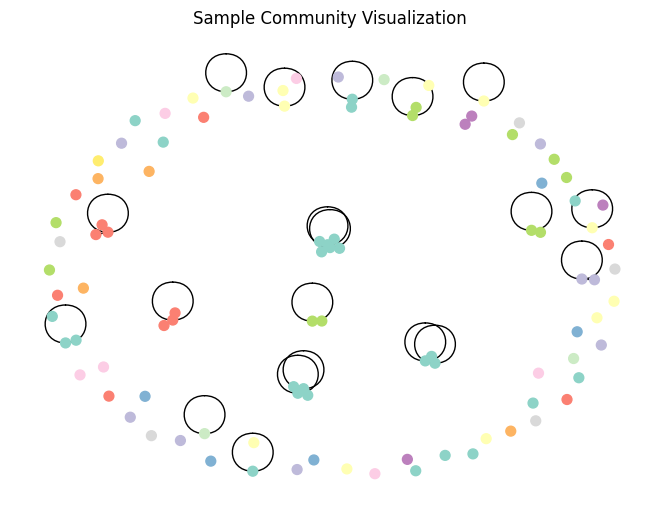

In [ ]:
sub_nodes = list(partition.keys())[:100]
subgraph = G.subgraph(sub_nodes)

colors = [partition[n] for n in subgraph.nodes()]
nx.draw(subgraph, node_color=colors, with_labels=False, node_size=50, cmap=plt.cm.Set3)
plt.title("Sample Community Visualization")
plt.show()


In [ ]:
from networkx.algorithms.community import label_propagation_communities

# Run the algorithm
print("Running Label Propagation...")
lp_communities = list(label_propagation_communities(G))

# Map each node to its community ID
lp_partition = {}
for i, comm in enumerate(lp_communities):
    for node in comm:
        lp_partition[node] = i

print("✅ Label Propagation communities:", len(lp_communities))


Running Label Propagation...
✅ Label Propagation communities: 3546


In [ ]:
# Get community ID for only labeled nodes
lp_labels = [lp_partition[i] for i in labeled_nodes]

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari_lp = adjusted_rand_score(labels, lp_labels)
nmi_lp = normalized_mutual_info_score(labels, lp_labels)

print(f"🔁 Label Propagation ARI: {ari_lp:.4f}")
print(f"🔁 Label Propagation NMI: {nmi_lp:.4f}")


🔁 Label Propagation ARI: 0.0011
🔁 Label Propagation NMI: 0.1671


In [ ]:
from networkx.algorithms.community import girvan_newman

# Extract small subgraph (e.g., first 200 nodes)
small_nodes = list(G.nodes)[:200]
subG = G.subgraph(small_nodes)

# Run Girvan–Newman
print("Running Girvan–Newman on small subgraph...")
gn_gen = girvan_newman(subG)
gn_communities = next(gn_gen)  # First level split

# Map nodes to community IDs
gn_partition = {}
for i, comm in enumerate(gn_communities):
    for node in comm:
        gn_partition[node] = i

print("✅ Girvan–Newman communities:", len(gn_communities))


Running Girvan–Newman on small subgraph...
✅ Girvan–Newman communities: 151


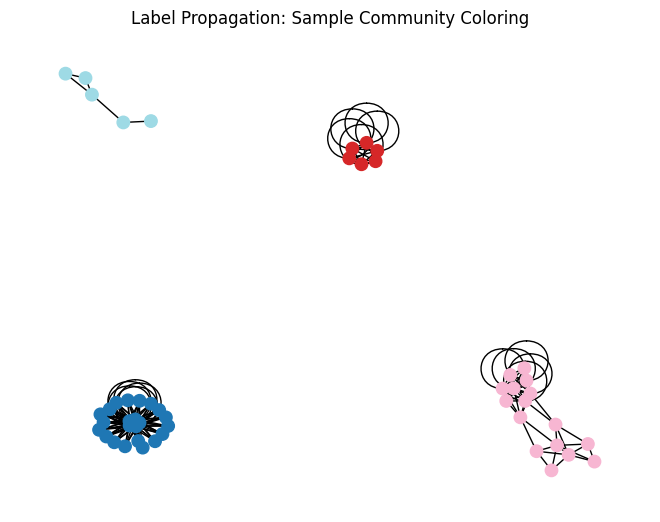

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Sample 50 nodes to avoid clutter
sample_nodes = list(lp_partition.keys())[:50]
subG = G.subgraph(sample_nodes)
colors = [lp_partition[n] for n in subG.nodes()]

nx.draw(subG, node_color=colors, with_labels=False, node_size=80, cmap=plt.cm.tab20)
plt.title("Label Propagation: Sample Community Coloring")
plt.show()


In [ ]:
def evaluate(model, data, idx):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        preds = logits[idx].argmax(dim=1)
        correct = (preds == data.y[idx]).sum().item()
        return correct / len(idx)

baseline_acc = evaluate(model, data, test_idx)
print(f"🎯 Baseline Test Accuracy: {baseline_acc:.4f}")


🎯 Baseline Test Accuracy: 0.5317


In [ ]:
import copy

def ablation_feature_importance(model, data, test_idx):
    importance_scores = []

    for i in range(data.x.shape[1]):
        x_modified = data.x.clone()
        x_modified[:, i] = 0  # zero-out feature i

        data_ablate = copy.deepcopy(data)
        data_ablate.x = x_modified

        acc = evaluate(model, data_ablate, test_idx)
        drop = baseline_acc - acc
        importance_scores.append(drop)

    return importance_scores


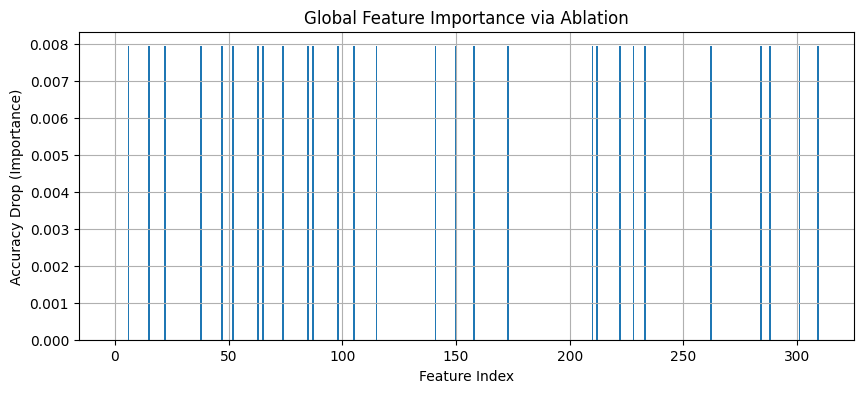

In [ ]:
import matplotlib.pyplot as plt

importance = ablation_feature_importance(model, data, test_idx)

plt.figure(figsize=(10, 4))
plt.bar(range(len(importance)), importance)
plt.xlabel("Feature Index")
plt.ylabel("Accuracy Drop (Importance)")
plt.title("Global Feature Importance via Ablation")
plt.grid(True)
plt.show()


# Phase A: BERT + Metadata-GNN Fusion

In [ ]:
from scipy.sparse import load_npz, hstack
bert = load_npz("/content/drive/MyDrive/Data/new_bert_feature.npz")
content = load_npz("/content/drive/MyDrive/Data/new_content_feature.npz")
combined = hstack([bert, content])  # or profile
x = torch.tensor(combined.toarray(), dtype=torch.float)


🔁 Phase B: Heterogeneous Graph (Multi-Edge-Type)


In [ ]:
from torch_geometric.data import HeteroData
data = HeteroData()
data['node'].x = x
data['node', 'speaker', 'node'].edge_index = ...
data['node', 'party', 'node'].edge_index = ...
...


Ellipsis

# Phase C: Temporal Evaluation

In [ ]:
from scipy.sparse import load_npz, hstack
import torch

# Load BERT embeddings (shape: 41054 × 768)
bert = load_npz("/content/drive/MyDrive/Data/new_bert_feature.npz")

# Load content or profile vectors
content = load_npz("/content/drive/MyDrive/Data/new_content_feature.npz")  # or new_profile_feature.npz

# Combine BERT + content/profile horizontally
fused_sparse = hstack([bert, content])  # Shape: 41054 × (768 + content_dim)

# Convert to dense PyTorch tensor
x = torch.tensor(fused_sparse.toarray(), dtype=torch.float)


In [ ]:
data.x = x  # Replace old TF-IDF or profile-only features


In [ ]:
# x is your fused feature tensor: shape (41054, D)
mean = x.mean(dim=0, keepdim=True)
std = x.std(dim=0, keepdim=True) + 1e-6  # avoid division by zero

x_scaled = (x - mean) / std
data.x = x_scaled


In [ ]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
model = GraphSAGE(
    in_channels=data.x.shape[1],
    hidden_channels=128,
    out_channels=2
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index, y=y)

In [ ]:
def evaluate(model, data, idx):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        preds = out[idx].argmax(dim=1)
        acc = (preds == data.y[idx]).sum().item() / len(idx)
    return acc

train_accs = []
test_accs = []

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == 49:
        train_acc = evaluate(model, data, train_idx)
        test_acc = evaluate(model, data, test_idx)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"Epoch {epoch:02d}: Loss={loss.item():.4f} | Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f}")


Epoch 00: Loss=0.7171 | Train Acc=0.5160 | Test Acc=0.4841
Epoch 05: Loss=0.8402 | Train Acc=0.5638 | Test Acc=0.5397
Epoch 10: Loss=0.6947 | Train Acc=0.6436 | Test Acc=0.6111
Epoch 15: Loss=0.6411 | Train Acc=0.6702 | Test Acc=0.5952
Epoch 20: Loss=0.6252 | Train Acc=0.6543 | Test Acc=0.6429
Epoch 25: Loss=0.5974 | Train Acc=0.6809 | Test Acc=0.6270
Epoch 30: Loss=0.5989 | Train Acc=0.6862 | Test Acc=0.6111
Epoch 35: Loss=0.5993 | Train Acc=0.7128 | Test Acc=0.5952
Epoch 40: Loss=0.5835 | Train Acc=0.7394 | Test Acc=0.6349
Epoch 45: Loss=0.5369 | Train Acc=0.6968 | Test Acc=0.6032
Epoch 49: Loss=0.5314 | Train Acc=0.7553 | Test Acc=0.6111


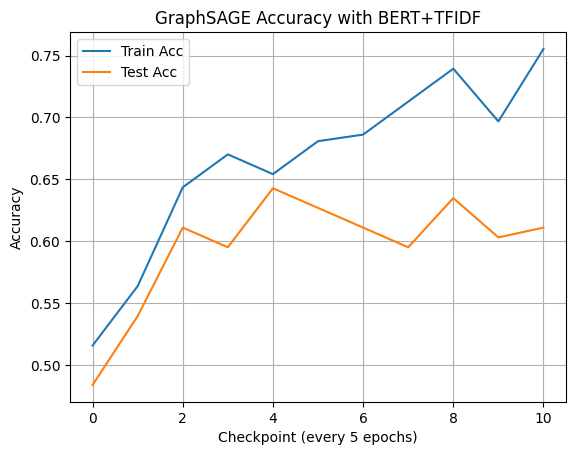

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.title("GraphSAGE Accuracy with BERT+TFIDF")
plt.xlabel("Checkpoint (every 5 epochs)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()
